<a href="https://colab.research.google.com/github/andrillion/Projects/blob/master/nurse_scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scheduling of nurses to shifts

In [ ]:
!pip install -q ortools
!pip install -q typing
!pip install -q matplotlib
!pip install -q seaborn


Day 1:
  Shift 1: Nurses [8, 9]
  Shift 2: Nurses [1, 4]
  Shift 3: Nurses [2, 5]
Day 2:
  Shift 1: Nurses [3, 4]
  Shift 2: Nurses [2, 5]
  Shift 3: Nurses [6, 9]
Day 3:
  Shift 1: Nurses [5, 7]
  Shift 2: Nurses [4, 6]
  Shift 3: Nurses [0, 3]
Day 4:
  Shift 1: Nurses [1, 6]
  Shift 2: Nurses [0, 5]
  Shift 3: Nurses [4, 8]
Day 5:
  Shift 1: Nurses [0, 7]
  Shift 2: Nurses [2, 9]
  Shift 3: Nurses [5, 6]
Day 6:
  Shift 1: Nurses [3, 9]
  Shift 2: Nurses [0, 8]
  Shift 3: Nurses [2, 7]
Day 7:
  Shift 1: Nurses [4, 8]
  Shift 2: Nurses [2, 7]
  Shift 3: Nurses [1, 3]


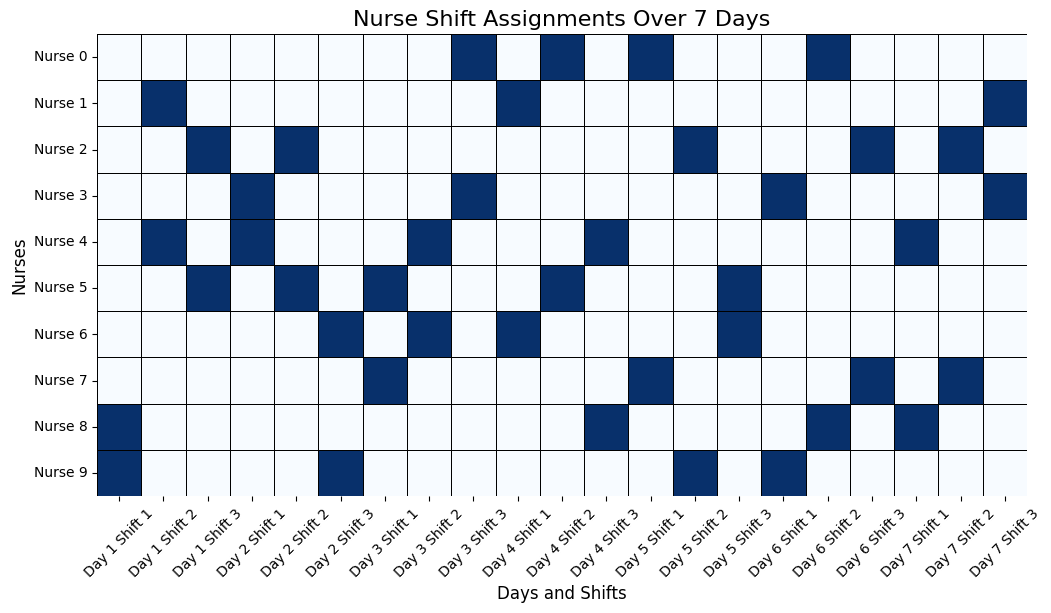

In [ ]:
from ortools.sat.python import cp_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def main():
    model = cp_model.CpModel()

    # Parameters
    num_nurses = 10
    num_days = 7
    num_shifts = 3

    # Creating variables
    shifts = {}
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts):
                shifts[(n, d, s)] = model.NewBoolVar(f'shift_n{n}_d{d}_s{s}')

    # Each shift must have exactly 2 nurses assigned
    for d in range(num_days):
        for s in range(num_shifts):
            model.Add(sum(shifts[(n, d, s)] for n in range(num_nurses)) == 2)

    # Each nurse can work at most one shift per day
    for n in range(num_nurses):
        for d in range(num_days):
            model.Add(sum(shifts[(n, d, s)] for s in range(num_shifts)) <= 1)

    # Each nurse should have at least one shift rest between two working shifts
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts - 1):  # Check for shifts within the same day
                model.Add(shifts[(n, d, s)] + shifts[(n, d, s + 1)] <= 1)  # Cannot work two consecutive shifts on the same day

    # Additional constraint: If a nurse works night shift (shift 3) on day d,
    # they cannot work morning shift (shift 1) on day d + 1
    for n in range(num_nurses):
        for d in range(num_days - 1):  # Loop until the second last day
            model.Add(shifts[(n, d, 2)] + shifts[(n, d + 1, 0)] <= 1)  # Night shift on day d and morning shift on day d+1

    # Preventing nurses from working the same shift on consecutive days
    for n in range(num_nurses):
        for d in range(num_days - 1):
            for s in range(num_shifts):
                model.Add(shifts[(n, d, s)] + shifts[(n, d + 1, s)] <= 1)  # Same shift on consecutive days

    # Adding constraints to ensure no repeated schedules across days
    for d in range(num_days - 1):
        for s in range(num_shifts):
            for n1 in range(num_nurses):
                for n2 in range(n1 + 1, num_nurses):
                    model.Add(shifts[(n1, d, s)] + shifts[(n2, d, s)] + shifts[(n1, d + 1, s)] + shifts[(n2, d + 1, s)] <= 3)

    # Each nurse must have 2 days completely off each week
    # Select two days off for each nurse
    days_off = {n: [] for n in range(num_nurses)}
    for n in range(num_nurses):
        days_off[n] = [n % num_days, (n + 1) % num_days]  # For simplicity, you can change the logic here for varied days off

    for n in range(num_nurses):
        for d in range(num_days):
            if d in days_off[n]:
                # Ensure no shifts on the days off
                for s in range(num_shifts):
                    model.Add(shifts[(n, d, s)] == 0)

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Initialize heatmap data
        heatmap_data = np.zeros((num_nurses, num_days * num_shifts))

        for d in range(num_days):
            print(f'Day {d + 1}:')
            for s in range(num_shifts):
                assigned_nurses = [n for n in range(num_nurses) if solver.Value(shifts[(n, d, s)]) == 1]
                print(f'  Shift {s + 1}: Nurses {assigned_nurses}')

                # Fill the heatmap data
                for nurse in assigned_nurses:
                    heatmap_data[nurse, d * num_shifts + s] = 1  # Mark the nurse as working

        # Create the heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

        # Add labels
        plt.title('Nurse Shift Assignments Over 7 Days', fontsize=16)
        plt.xlabel('Days and Shifts', fontsize=12)
        plt.ylabel('Nurses', fontsize=12)
        plt.xticks(ticks=np.arange(num_days * num_shifts) + 0.5,
                   labels=[f'Day {i // 3 + 1} Shift {i % 3 + 1}' for i in range(num_days * num_shifts)],
                   rotation=45)
        plt.yticks(ticks=np.arange(num_nurses) + 0.5,
                   labels=[f'Nurse {i}' for i in range(num_nurses)],
                   rotation=0)

        plt.show()
    else:
        print('No solution found!')

if __name__ == "__main__":
    main()
